### Tensorflow setup

In [38]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Every import needed

In [39]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns

import os 
import pathlib 
import time

# Convert dataset to numpy function
from tensorflow.data import Dataset

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.utils import to_categorical
from itertools import cycle
from sklearn.metrics import auc

import pandas as pd

### Load images

In [40]:
PATH = '.\\..\\dataset\\micro_expressions' 

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

print(train_dir)
print(test_dir)

.\..\dataset\micro_expressions\train
.\..\dataset\micro_expressions\test


In [41]:
import pathlib 

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

6938
1700


In [42]:
batch_size = 32
IMG_SIZE = (80, 80)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.15,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.15,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None, 
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 6938 files belonging to 7 classes.
Using 5898 files for training.
Found 6938 files belonging to 7 classes.
Using 1040 files for validation.
Found 1700 files belonging to 7 classes.


### Util functions used in the code

In [43]:
# Convert dataset to numpy
def batch_dataset_to_numpy(ds):
    in_data = []
    out_data = []
    for inp, out in ds:
        
        array = inp.numpy()
        for x in array:
            in_data.append(x)
            
        array = out.numpy()
        for x in array:
            out_data.append(x)
    
    return in_data, out_data


X_train, y_train = batch_dataset_to_numpy(train_ds)
X_val, y_val = batch_dataset_to_numpy(val_ds)
X_test, y_test = batch_dataset_to_numpy(test_ds)

In [44]:
def print_metrics_by_class(array, title=None, is_rate=False):
    i = 0
    print(title)
    
    for k in class_names:
        if is_rate == True:
            print('\t%s -> %.3f%%' %(k, array[i]))
        else:
            print('\t%s -> %.0f' %(k, array[i]))
        
        i = i + 1

def print_confusion_matrix_metrics(cnf_matrix):
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    print_metrics_by_class(FP, '\nFalse Positives:\n')
    print_metrics_by_class(FN, '\nFalse Negatives:\n')
    print_metrics_by_class(TP, '\nTrue Positives:\n')
    print_metrics_by_class(TN, '\nTrue Negatives:\n')
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print_metrics_by_class(TPR, '\nTrue Positive Rate:\n', is_rate=True)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print_metrics_by_class(TNR, '\nTrue Negative Rate:\n', is_rate=True)
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print_metrics_by_class(PPV, '\nPositive Predictive Value:\n')
    
    # Negative predictive value
    NPV = TN/(TN+FN)
    print_metrics_by_class(NPV, '\nNegative Predictive Value:\n')
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print_metrics_by_class(FPR, '\nFalse Positive Rate:\n', is_rate=True)
    
    # False negative rate
    FNR = FN/(TP+FN)
    print_metrics_by_class(FNR, '\nFalse Negative Rate:\n', is_rate=True)
    
    # False discovery rate
    FDR = FP/(TP+FP)
    print_metrics_by_class(FDR, '\nFalse Discovery Rate:\n', is_rate=True)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print_metrics_by_class(ACC, '\nAccuracy:\n', is_rate=True)

def plot_confusion_matrix(y_pred, y_test, labels, normalize_m=None, return_m=False):
    
    fig, ax = plt.subplots(figsize=(10,10))
    matrix = confusion_matrix(y_test, tf.argmax(y_pred, axis=-1), normalize=normalize_m)
    
    fmt_m = '2'
    if normalize_m != None:
        fmt_m = '.3f'
        
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt=fmt_m, 
        cmap='Blues',
        cbar=False, 
        xticklabels=class_names, 
        yticklabels=class_names, 
        ax=ax
    )
    
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('Real Label', fontsize = 15) 
    plt.xlabel('Predicted Label', fontsize = 15) 
    plt.show()
    
    if return_m == True:
        return matrix

def plot_loss_and_accuracy(history):
    
    history_data_frame = pd.DataFrame(history.history)  

    print(history_data_frame.loc[:, [ 'accuracy']].max(), history_data_frame.loc[:, [ 'val_accuracy']].max())

    plt.figure(figsize=(15,10))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, linestyle='-', marker='.', color='b', label="Training loss")
    plt.plot(epochs, val_loss, linestyle='-', marker='.', color='r', label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show();

    plt.clf()
    plt.figure(figsize=(15,10))
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plt.plot(epochs, acc, linestyle='-', marker='.', color='b', label="Training accuracy")
    plt.plot(epochs, val_acc, linestyle='-', marker='.', color='r', label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

def print_dataset_class_balance(class_names, y, title=None):
    print(title)
    y_np = np.array(y)
    length = len(y_np)
    
    for i, x  in enumerate(class_names):
        count = len(y_np[y_np == i])
        print(f" {class_names[i]} = {(count/length):.2f} %")
        
    print('\n')


def batch_dataset_to_numpy(ds):
    in_data = []
    out_data = []
    for inp, out in ds:
        
        array = inp.numpy()
        for x in array:
            in_data.append(x)
            
        array = out.numpy()
        for x in array:
            out_data.append(x)
    
    return in_data, out_data
    
def prinf_dataset_information(): 
    # Cardinality (number of batches)
    print('Train Cardinality (number of batches): ', train_ds.cardinality().numpy())
    print('Validation cardinality (number of batches): ', val_ds.cardinality().numpy())
    print('Test cardinality (number of batches): ', test_ds.cardinality().numpy(), end='\n\n')

    print('Class names: ', class_names, end='\n\n')
    
    print('Shape of X_train: ', np.array(X_train).shape)
    print('Shape of y_train: ', np.array(y_train).shape, end='\n\n')
    print('Shape of X_val: ', np.array(X_val).shape)
    print('Shape of y_val: ', np.array(y_val).shape, end='\n\n')
    print('Shape of X_test: ', np.array(X_test).shape)
    print('Shape of y_test: ', np.array(y_test).shape, end='\n\n')
    
    print_dataset_class_balance(class_names, y_train, 'Class Balance - Train Data:\n')
    print_dataset_class_balance(class_names, y_val, 'Class Balance - Validation Data:\n')
    print_dataset_class_balance(class_names, y_test, 'Class Balance - Test Data:\n')
    

In [45]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

graph_colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'blue', 'grey']

def plot_multiclass_roc_curve(y_test, y_pred, class_names, single_class = None, title = None):
    
    if title == None:
        title = ''
    
    # Binarize the output
    y_b = to_categorical(y_test, num_classes = len(class_names))
    yp = y_pred

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresh = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[str(i)], tpr[str(i)], thresh[str(i)] = roc_curve(y_b[:, i], yp[:, i])
        roc_auc[str(i)] = auc(fpr[str(i)], tpr[str(i)])

    lw = 2 # linewidth
    
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], thresh['micro'] = roc_curve(y_b.ravel(), yp.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[str(i)] for i in range(len(class_names))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[str(i)], tpr[str(i)])
    
    # Finally average it and compute AUC
    mean_tpr /= len(class_names)

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    # Plot all ROC curves
    plt.figure(figsize=(15,15))
    plt.plot(
        fpr['micro'], 
        tpr['micro'],
        label = 'Micro-Avg (area = {0:0.2f})'.format(roc_auc['micro']),
        color = 'deeppink',
        linestyle = '--', 
        linewidth = lw
    );

    plt.plot(
        fpr['macro'], 
        tpr['macro'],
        label = 'Macro-Avg (area = {0:0.2f})'.format(roc_auc['macro']),
        color = 'navy', 
        linestyle = '--', 
        linewidth = lw
    );

    colors = cycle(graph_colors)
    for i, color in zip(range(len(class_names)), colors):
        if single_class == None:
            plt.plot(
                fpr[str(i)], 
                tpr[str(i)], 
                color = color, 
                lw = lw,
                label = 'ROC - "{0}" (area = {1:0.2f})'.format(class_names[i].capitalize(), roc_auc[str(i)])
            );
        else:
            if single_class == i:
                plt.plot(
                    fpr[str(i)], 
                    tpr[str(i)], 
                    color = color, 
                    lw = lw,
                    label = 'ROC - "{0}" (area = {1:0.2f})'.format(class_names[i].capitalize(), roc_auc[str(i)])
                );
            
    
    plt.plot([0, 1],[0, 1], 'k--', lw = lw, label = 'Random Guessing')
    plt.xlim([-0.025, 1.0])
    plt.ylim([0.0, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (TPR vs FPR)' + title)
    plt.legend(loc = 'lower right')
    plt.show()
    
    
    macro_roc_auc_ovo = roc_auc_score(y_b, yp, multi_class="ovo",
                                          average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_b, yp, multi_class="ovo",
                                             average="weighted")
    
    macro_roc_auc_ovr = roc_auc_score(y_b, yp, multi_class="ovr",
                                          average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_b, yp, multi_class="ovr",
                                             average="weighted")
    
    print("One-vs-One ROC AUC scores:\n\t{:.6f} (macro),\n\t{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n\t{:.6f} (macro),\n\t{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

In [46]:
def print_general_metrics(y_pred, y_test):
    pred = tf.argmax(y_pred, axis = -1)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, pred, average='weighted')
    
    
    print('\nClassification Report:\n')    
    print(classification_report(y_test, pred), end='\n\n')
    
    print('Accuracy: %.3f\n' % accuracy_score(y_test, pred)) 
    print('Balanced accuracy: %.3f\n' % balanced_accuracy_score(y_test, pred))
    print('F1_Score: %.3f\n' % f1_score(y_test, pred, average='weighted'))
    print('Precision: %.3f\n' % precision)    
    print('Recall: %.3f\n' % recall)
    print('ROC AUC (OVR): %.3f\n' % roc_auc_score(y_test, y_pred, multi_class = 'ovr'))
    print('ROC AUC (OVO): %.3f\n\n' % roc_auc_score(y_test, y_pred, multi_class = 'ovo'))

### Dataset overview

In [47]:
prinf_dataset_information()

Train Cardinality (number of batches):  185
Validation cardinality (number of batches):  33
Test cardinality (number of batches):  54

Class names:  ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

Shape of X_train:  (5898, 80, 80, 3)
Shape of y_train:  (5898,)

Shape of X_val:  (1040, 80, 80, 3)
Shape of y_val:  (1040,)

Shape of X_test:  (1700, 80, 80, 3)
Shape of y_test:  (1700,)

Class Balance - Train Data:

 anger = 0.19 %
 disgust = 0.08 %
 fear = 0.06 %
 happiness = 0.25 %
 neutral = 0.08 %
 sadness = 0.19 %
 surprise = 0.14 %


Class Balance - Validation Data:

 anger = 0.17 %
 disgust = 0.09 %
 fear = 0.06 %
 happiness = 0.27 %
 neutral = 0.08 %
 sadness = 0.17 %
 surprise = 0.14 %


Class Balance - Test Data:

 anger = 0.19 %
 disgust = 0.08 %
 fear = 0.06 %
 happiness = 0.25 %
 neutral = 0.08 %
 sadness = 0.19 %
 surprise = 0.14 %




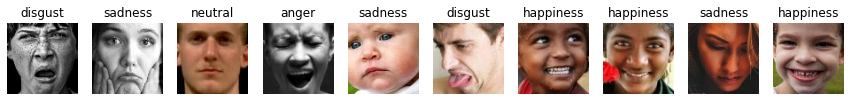

In [48]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))   
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Beggining of Tensorflow analysis

### Base model without data augmentation 

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 3))

x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(120, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(90, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(60, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 120)       69240     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 120)         0     

In [50]:
L = keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

In [51]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
) 

Epoch 1/50
185/185 [==============================] - 2s 8ms/step - loss: 1.8441 - accuracy: 0.2567 - val_loss: 1.6502 - val_accuracy: 0.3683
Epoch 2/50
185/185 [==============================] - 1s 7ms/step - loss: 1.6568 - accuracy: 0.3694 - val_loss: 1.4549 - val_accuracy: 0.4702
Epoch 3/50
185/185 [==============================] - 1s 7ms/step - loss: 1.5331 - accuracy: 0.4262 - val_loss: 1.3602 - val_accuracy: 0.5192
Epoch 4/50
185/185 [==============================] - 1s 7ms/step - loss: 1.4303 - accuracy: 0.4742 - val_loss: 1.2760 - val_accuracy: 0.5356
Epoch 5/50
185/185 [==============================] - 1s 7ms/step - loss: 1.3679 - accuracy: 0.4941 - val_loss: 1.1834 - val_accuracy: 0.5683
Epoch 6/50
185/185 [==============================] - 1s 7ms/step - loss: 1.2965 - accuracy: 0.5227 - val_loss: 1.1442 - val_accuracy: 0.5856
Epoch 7/50
185/185 [==============================] - 1s 7ms/step - loss: 1.2172 - accuracy: 0.5605 - val_loss: 1.0952 - val_accuracy: 0.6029
Epoch 

accuracy    0.867243
dtype: float64 val_accuracy    0.750962
dtype: float64


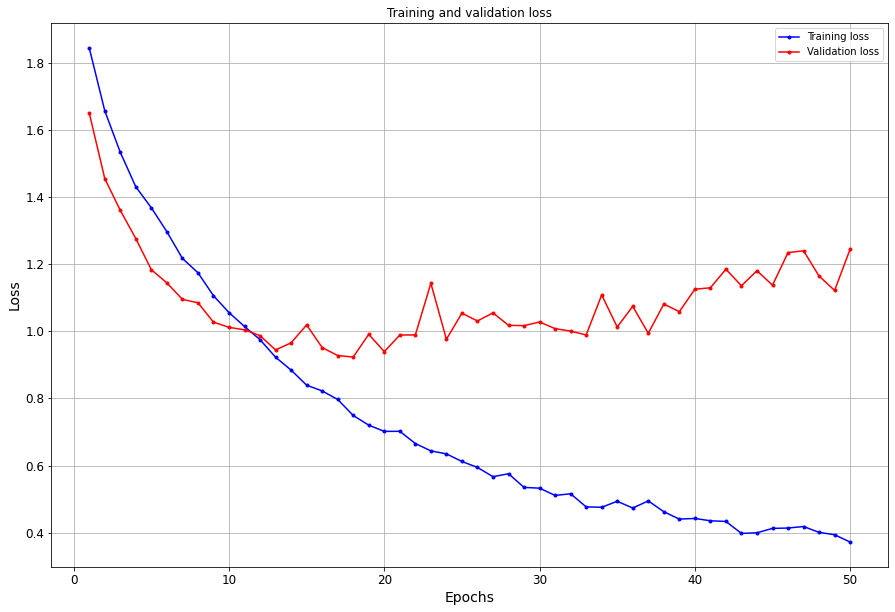

<Figure size 432x288 with 0 Axes>

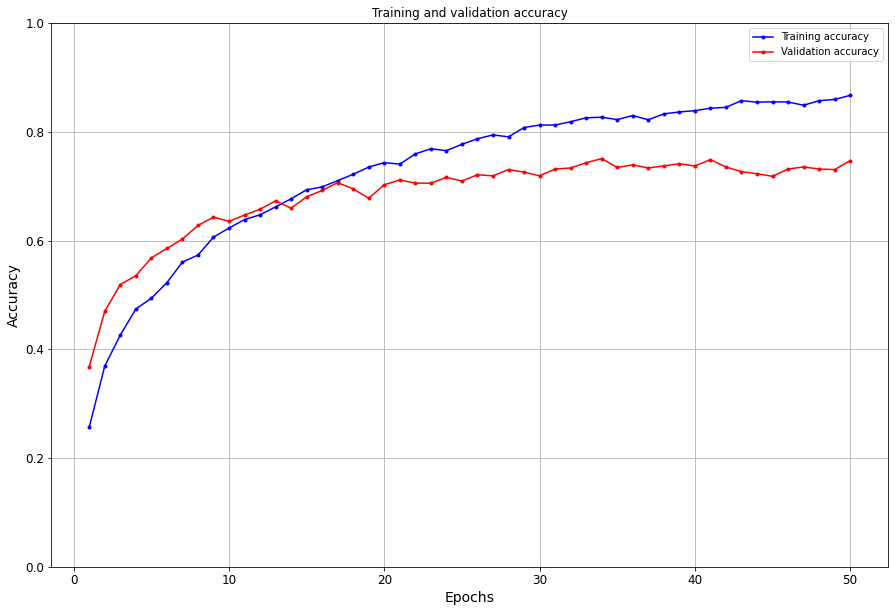

In [52]:
plot_loss_and_accuracy(history)

In [53]:
model.evaluate(test_ds)

54/54 [==============================] - 0s 4ms/step - loss: 1.5071 - accuracy: 0.7165


[1.507069706916809, 0.7164705991744995]

In [54]:
# y_pred are probs, we have to convert them to int
y_pred = model.predict(test_ds) 

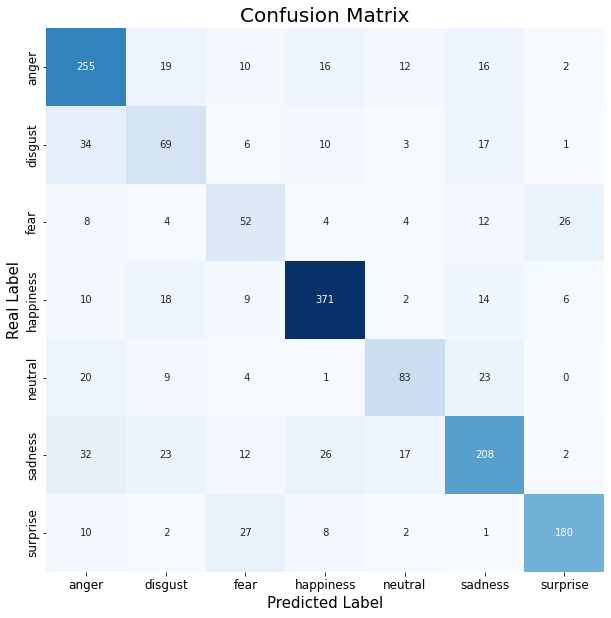

In [55]:
cnf_matrix = plot_confusion_matrix(y_pred, y_test, class_names, return_m=True)

In [56]:
print_confusion_matrix_metrics(cnf_matrix)


False Positives:

	anger -> 114
	disgust -> 75
	fear -> 68
	happiness -> 65
	neutral -> 40
	sadness -> 83
	surprise -> 37

False Negatives:

	anger -> 75
	disgust -> 71
	fear -> 58
	happiness -> 59
	neutral -> 57
	sadness -> 112
	surprise -> 50

True Positives:

	anger -> 255
	disgust -> 69
	fear -> 52
	happiness -> 371
	neutral -> 83
	sadness -> 208
	surprise -> 180

True Negatives:

	anger -> 1256
	disgust -> 1485
	fear -> 1522
	happiness -> 1205
	neutral -> 1520
	sadness -> 1297
	surprise -> 1433

True Positive Rate:

	anger -> 0.773%
	disgust -> 0.493%
	fear -> 0.473%
	happiness -> 0.863%
	neutral -> 0.593%
	sadness -> 0.650%
	surprise -> 0.783%

True Negative Rate:

	anger -> 0.917%
	disgust -> 0.952%
	fear -> 0.957%
	happiness -> 0.949%
	neutral -> 0.974%
	sadness -> 0.940%
	surprise -> 0.975%

Positive Predictive Value:

	anger -> 1
	disgust -> 0
	fear -> 0
	happiness -> 1
	neutral -> 1
	sadness -> 1
	surprise -> 1

Negative Predictive Value:

	anger -> 1
	disgust -> 1
	fear ->

In [57]:
print_general_metrics(y_pred, y_test)


Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       330
           1       0.48      0.49      0.49       140
           2       0.43      0.47      0.45       110
           3       0.85      0.86      0.86       430
           4       0.67      0.59      0.63       140
           5       0.71      0.65      0.68       320
           6       0.83      0.78      0.81       230

    accuracy                           0.72      1700
   macro avg       0.67      0.66      0.66      1700
weighted avg       0.72      0.72      0.72      1700


Accuracy: 0.716

Balanced accuracy: 0.661

F1_Score: 0.717

Precision: 0.719

Recall: 0.716

ROC AUC (OVR): 0.923

ROC AUC (OVO): 0.910




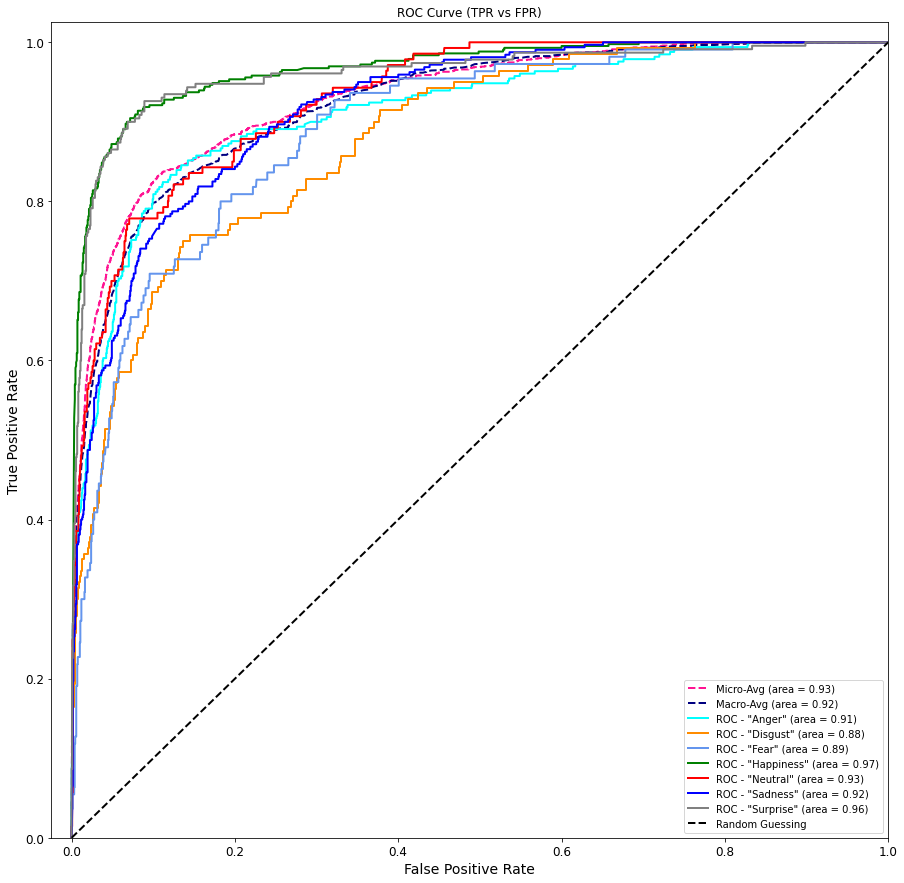

One-vs-One ROC AUC scores:
	0.922703 (macro),
	0.931220 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.922703 (macro),
	0.931220 (weighted by prevalence)


In [58]:
plot_multiclass_roc_curve(y_test, y_pred, class_names)

### Create data augmentation

In [59]:
import random  

transformations = [
    layers.RandomFlip("horizontal",input_shape=(80, 80, 3)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant" ,input_shape=(80, 80, 3)),
    layers.RandomZoom(0.2,  fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomRotation(0.05, fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomContrast(factor=[0.5, 1.3],input_shape=(80, 80, 3)),
    layers.GaussianNoise(0.03)
]     

def customDataAugmentationLayer(input):
    if random.random() > 0.5 :  
        return random.choice(transformations)(input)
    else:  
        result = input 
        for transformation in transformations:
            result = transformation(result)
        
        return result

dataAug = layers.Lambda(lambda input: customDataAugmentationLayer(input))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


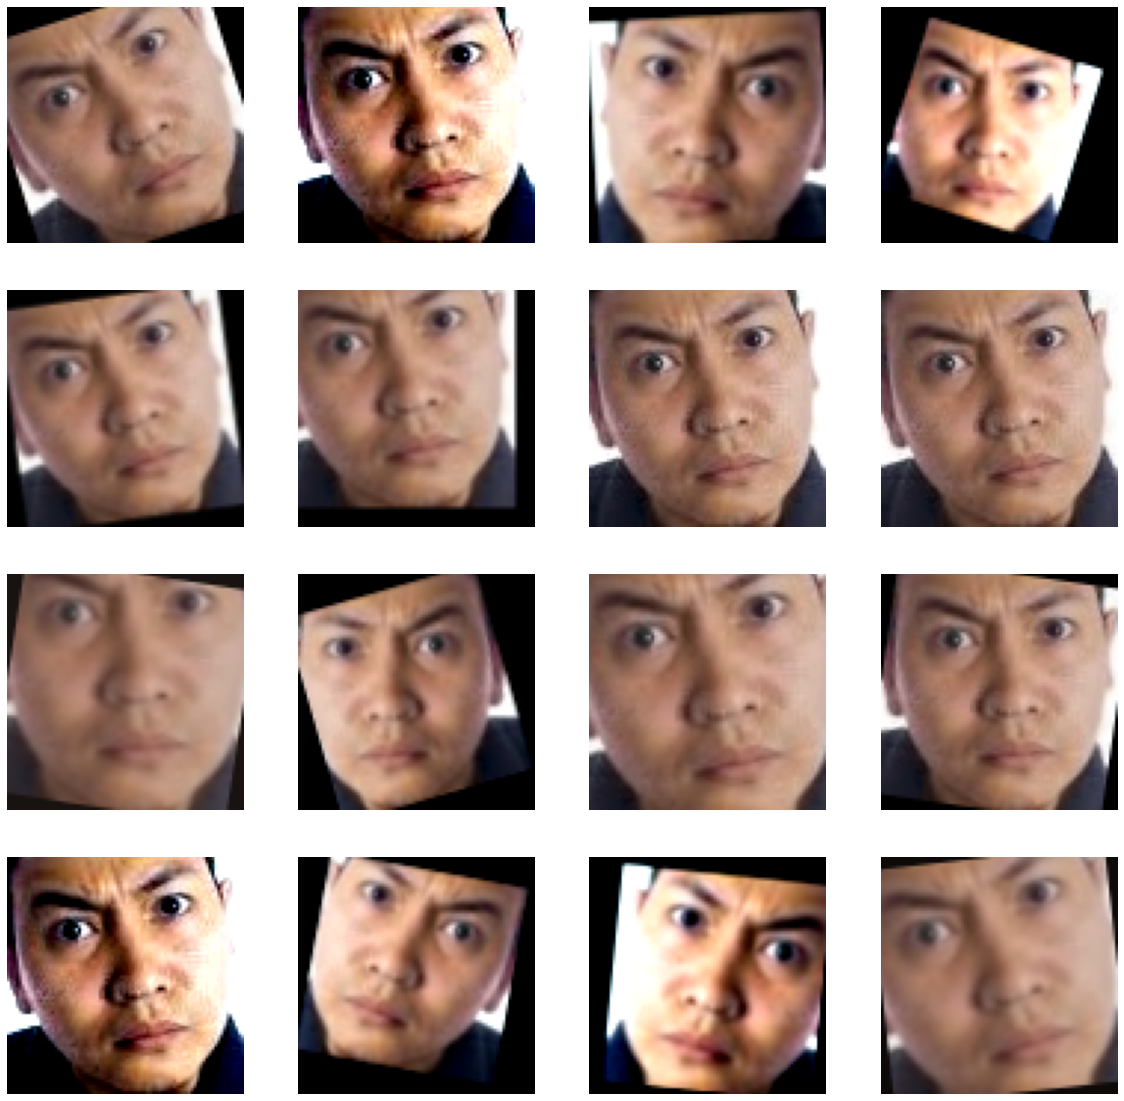

In [60]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(16):
        augmented_images = dataAug(images)
        #augmented_images = CustomDataAugmentationLayer()(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[12].numpy().astype("float32"))
        plt.axis("off")


## Improved CNN

In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 3))

x = keras.Sequential(transformations)(inputs) 

x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.Activation("relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.1)(x)


x = layers.Flatten()(x) 
x = layers.BatchNormalization()(x)  
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(60, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(30, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)

outputs = keras.layers.Dense(7, activation="softmax")(x) 

modelWithAugmentation = keras.Model(inputs=inputs, outputs=outputs)
modelWithAugmentation.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128   

In [62]:
# Tensorboard Logs
root_logdir = os.path.join(os.curdir, 'tensorboard_logs_CNN')

# Sub-diretoria onde ficarão os dados da execução: tem um nome criado a partir da hora de inicio
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

best_model_file_path = "model_CNN.hdf5"

callbacks_list = [
    keras.callbacks.TensorBoard(
        get_run_logdir(), 
        histogram_freq = 1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience = 500, 
        min_delta = 0.005, 
        restore_best_weights = True,
        mode='auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = best_model_file_path,
        monitor = "val_accuracy",
        verbose=0,
        save_best_only = True,
        save_weights_only = False,
        mode='max'
    )
]

# Compilar e treinar
#from keras.callbacks import ModelCheckpoint
#filepath = 'my_best_model.hdf5'
#checkpoint = ModelCheckpoint(filepath=filepath, 
#                             monitor='val_accuracy',
#                             verbose=0, 
#                             save_best_only=True,
#                             mode='max')
#callbacks = [checkpoint]

In [63]:
L = keras.losses.SparseCategoricalCrossentropy()

modelWithAugmentation.compile(loss=L, optimizer="adam", metrics=["accuracy"])

history = modelWithAugmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=callbacks_list
)

Epoch 1/200
185/185 [==============================] - 10s 43ms/step - loss: 2.1864 - accuracy: 0.1931 - val_loss: 3.4879 - val_accuracy: 0.1750
Epoch 2/200
185/185 [==============================] - 7s 39ms/step - loss: 1.9369 - accuracy: 0.2599 - val_loss: 1.9714 - val_accuracy: 0.2500
Epoch 3/200
185/185 [==============================] - 7s 39ms/step - loss: 1.7552 - accuracy: 0.3410 - val_loss: 1.8187 - val_accuracy: 0.3250
Epoch 4/200
185/185 [==============================] - 7s 38ms/step - loss: 1.5977 - accuracy: 0.4137 - val_loss: 1.4470 - val_accuracy: 0.4894
Epoch 5/200
185/185 [==============================] - 7s 38ms/step - loss: 1.4905 - accuracy: 0.4556 - val_loss: 1.4694 - val_accuracy: 0.4606
Epoch 6/200
185/185 [==============================] - 7s 38ms/step - loss: 1.3889 - accuracy: 0.5015 - val_loss: 1.2969 - val_accuracy: 0.5356
Epoch 7/200
185/185 [==============================] - 7s 38ms/step - loss: 1.3293 - accuracy: 0.5273 - val_loss: 1.7715 - val_accuracy

accuracy    0.961851
dtype: float64 val_accuracy    0.856731
dtype: float64


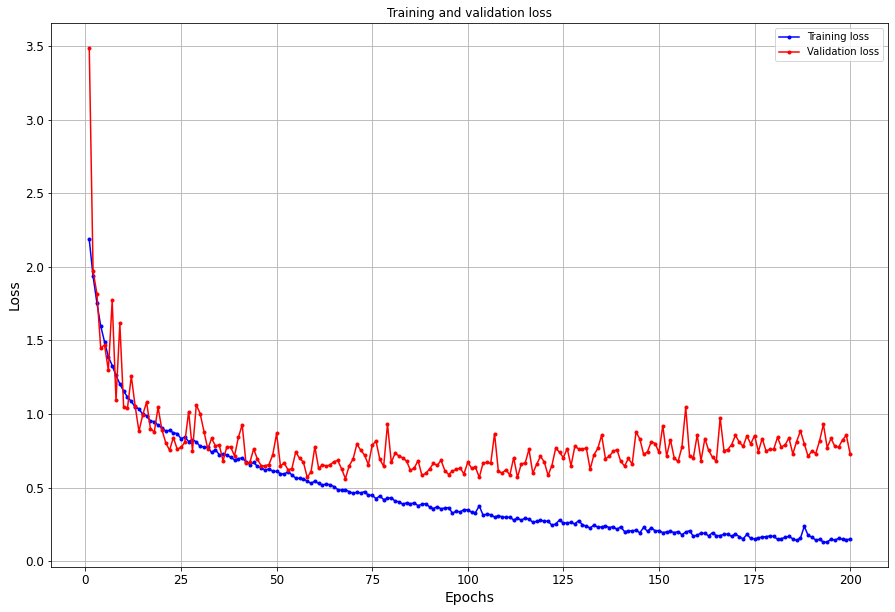

<Figure size 432x288 with 0 Axes>

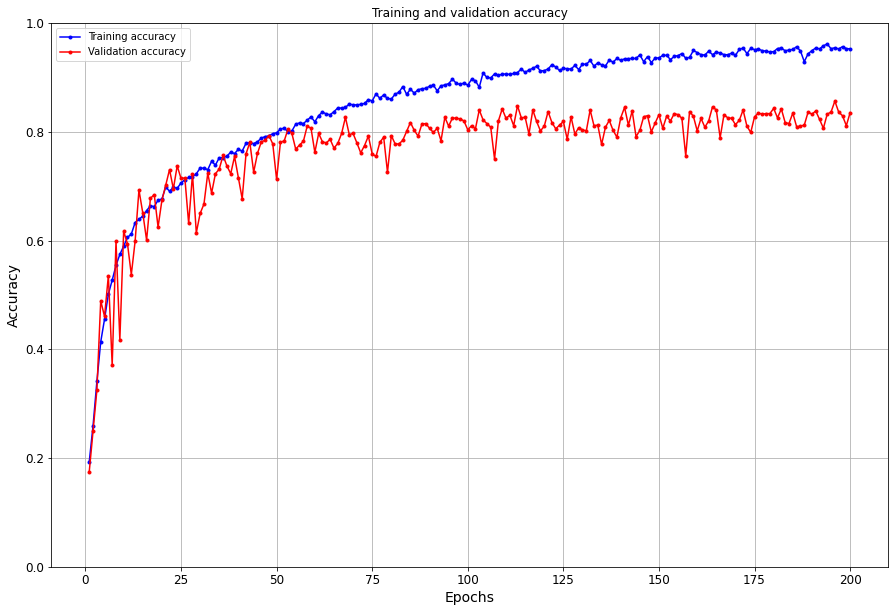

In [64]:
plot_loss_and_accuracy(history)

In [80]:
modelWithAugmentation.evaluate(test_ds)

54/54 [==============================] - 1s 16ms/step - loss: 0.9021 - accuracy: 0.8082


[0.9020760655403137, 0.8082352876663208]

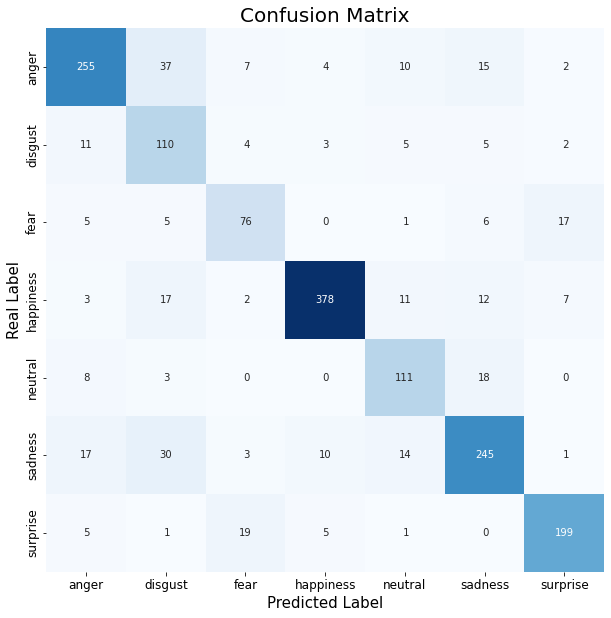

In [81]:
y_pred = modelWithAugmentation.predict(test_ds) 
cnf_matrix = plot_confusion_matrix(y_pred, y_test, class_names, return_m=True)

In [82]:
print_confusion_matrix_metrics(cnf_matrix)


False Positives:

	anger -> 49
	disgust -> 93
	fear -> 35
	happiness -> 22
	neutral -> 42
	sadness -> 56
	surprise -> 29

False Negatives:

	anger -> 75
	disgust -> 30
	fear -> 34
	happiness -> 52
	neutral -> 29
	sadness -> 75
	surprise -> 31

True Positives:

	anger -> 255
	disgust -> 110
	fear -> 76
	happiness -> 378
	neutral -> 111
	sadness -> 245
	surprise -> 199

True Negatives:

	anger -> 1321
	disgust -> 1467
	fear -> 1555
	happiness -> 1248
	neutral -> 1518
	sadness -> 1324
	surprise -> 1441

True Positive Rate:

	anger -> 0.773%
	disgust -> 0.786%
	fear -> 0.691%
	happiness -> 0.879%
	neutral -> 0.793%
	sadness -> 0.766%
	surprise -> 0.865%

True Negative Rate:

	anger -> 0.964%
	disgust -> 0.940%
	fear -> 0.978%
	happiness -> 0.983%
	neutral -> 0.973%
	sadness -> 0.959%
	surprise -> 0.980%

Positive Predictive Value:

	anger -> 1
	disgust -> 1
	fear -> 1
	happiness -> 1
	neutral -> 1
	sadness -> 1
	surprise -> 1

Negative Predictive Value:

	anger -> 1
	disgust -> 1
	fear ->

In [83]:
print_general_metrics(y_pred, y_test)


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       330
           1       0.54      0.79      0.64       140
           2       0.68      0.69      0.69       110
           3       0.94      0.88      0.91       430
           4       0.73      0.79      0.76       140
           5       0.81      0.77      0.79       320
           6       0.87      0.87      0.87       230

    accuracy                           0.81      1700
   macro avg       0.77      0.79      0.78      1700
weighted avg       0.82      0.81      0.81      1700


Accuracy: 0.808

Balanced accuracy: 0.793

F1_Score: 0.812

Precision: 0.822

Recall: 0.808

ROC AUC (OVR): 0.959

ROC AUC (OVO): 0.958




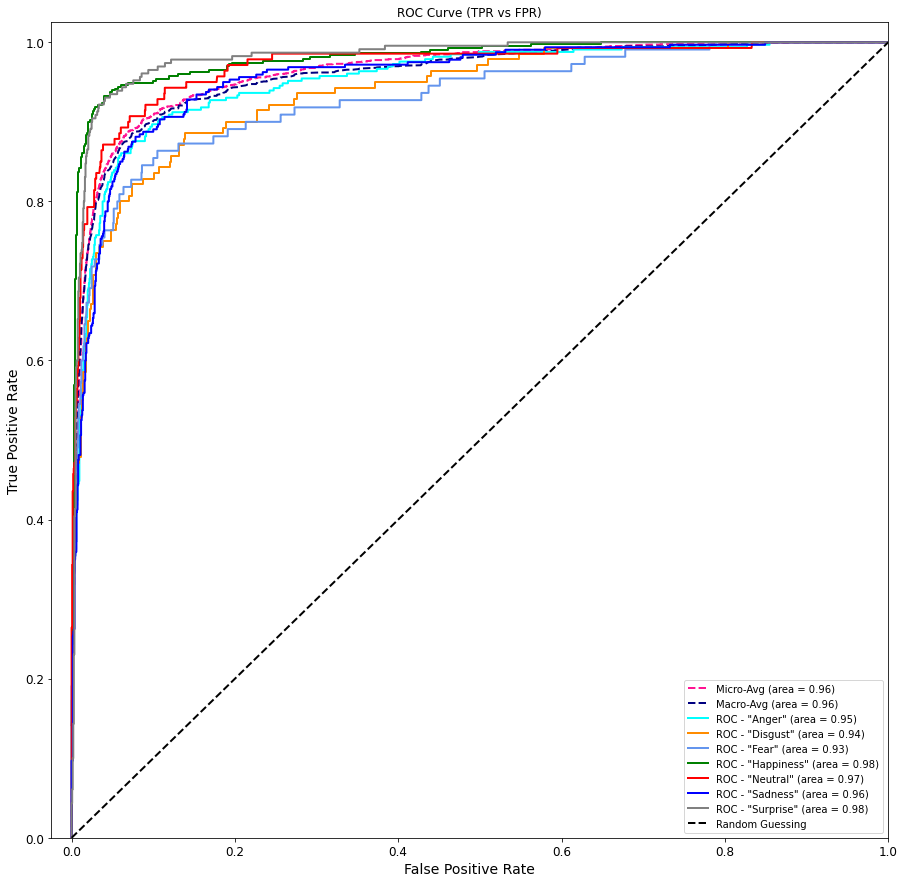

One-vs-One ROC AUC scores:
	0.958685 (macro),
	0.963208 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.958685 (macro),
	0.963208 (weighted by prevalence)


In [84]:
plot_multiclass_roc_curve(y_test, y_pred, class_names)

In [85]:
# Start TensorBoard
%load_ext tensorboard
# --port=6006
# --host=127.0.0.1
%tensorboard --logdir=./tensorboard_logs_CNN_V1_Rafael --host=127.0.0.1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24208), started 1:03:38 ago. (Use '!kill 24208' to kill it.)

### Apply trained model to new images

In [90]:
from keras.models import load_model  
model = load_model(best_model_file_path)
model.evaluate(test_ds)

54/54 [==============================] - 1s 10ms/step - loss: 0.8130 - accuracy: 0.8382


[0.8130242824554443, 0.8382353186607361]

In [91]:
from keras.preprocessing import image

def predict_new_image(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(80,80))  
    img_as_array = image.img_to_array(img)
    plt.imshow( img_as_array / 255)
    
    x=img_as_array
    x= x/ 255.
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=16)

    print(classes.argmax(axis=-1))
    print(class_names)
    print(np.array(class_names)[classes.argmax(axis=-1)])

[3]
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
['happiness']


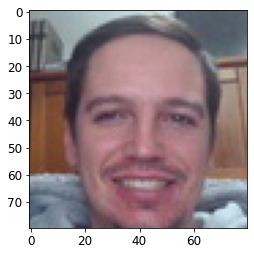

In [95]:
predict_new_image("im1.jpg", model, class_names)

[5]
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
['sadness']


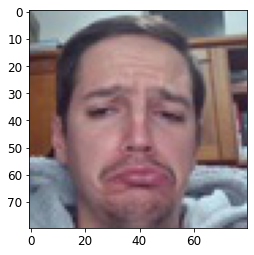

In [96]:
predict_new_image("im2.jpg", model, class_names)